In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

# load the data

In [ ]:
file_path = "/content/gym_members_exercise_tracking.csv"
df = pd.read_csv(file_path)

In [ ]:
print(df.head())

   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
0                      1.69           1313.0         Yoga            12.6   
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0              

In [ ]:
print(df.shape)

(973, 15)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [ ]:
print(df.isnull().sum())

Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64


In [ ]:
print(df.describe().T)

                               count        mean         std     min     25%  \
Age                            973.0   38.683453   12.180928   18.00   28.00   
Weight (kg)                    973.0   73.854676   21.207500   40.00   58.10   
Height (m)                     973.0    1.722580    0.127720    1.50    1.62   
Max_BPM                        973.0  179.883864   11.525686  160.00  170.00   
Avg_BPM                        973.0  143.766701   14.345101  120.00  131.00   
Resting_BPM                    973.0   62.223022    7.327060   50.00   56.00   
Session_Duration (hours)       973.0    1.256423    0.343033    0.50    1.04   
Calories_Burned                973.0  905.422405  272.641516  303.00  720.00   
Fat_Percentage                 973.0   24.976773    6.259419   10.00   21.30   
Water_Intake (liters)          973.0    2.626619    0.600172    1.50    2.20   
Workout_Frequency (days/week)  973.0    3.321686    0.913047    2.00    3.00   
Experience_Level               973.0    

# EDA

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nValue Counts for {col}:")
    print(df[col].value_counts())


Value Counts for Gender:
Gender
Male      511
Female    462
Name: count, dtype: int64

Value Counts for Workout_Type:
Workout_Type
Strength    258
Cardio      255
Yoga        239
HIIT        221
Name: count, dtype: int64


In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(numerical_cols)

Index(['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
       'Water_Intake (liters)', 'Workout_Frequency (days/week)',
       'Experience_Level', 'BMI'],
      dtype='object')


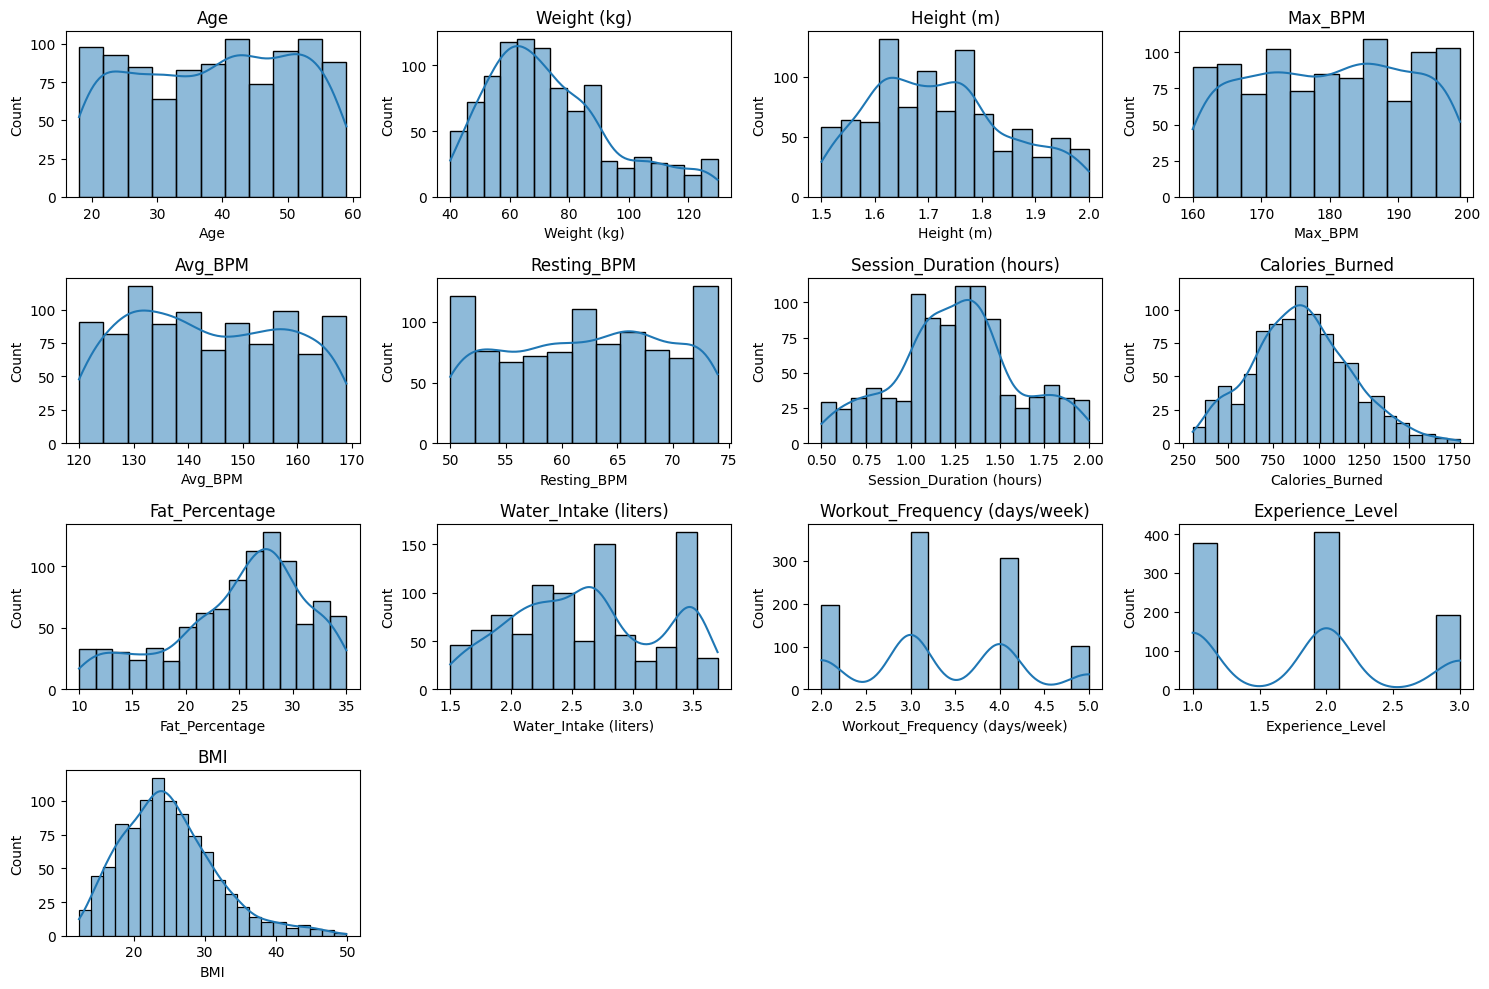

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.tight_layout()
plt.show()

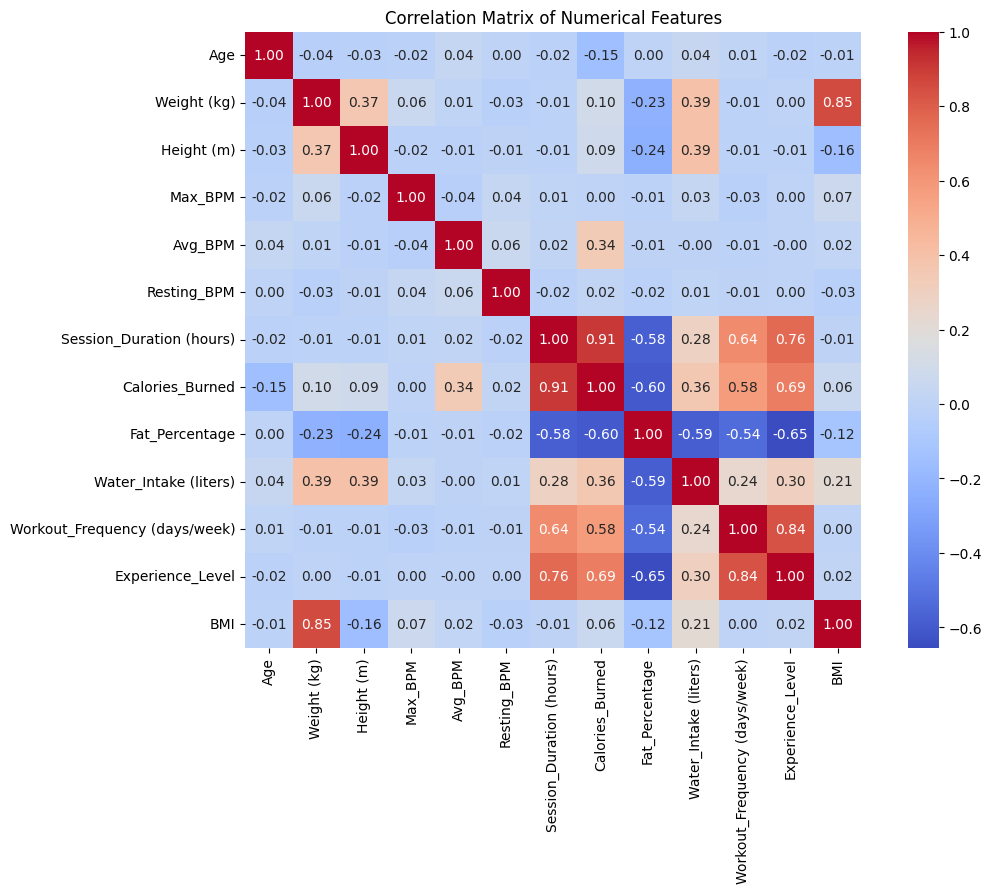


Highly Correlated Feature Pairs (|correlation| >= 0.75):
Calories_Burned                Session_Duration (hours)         0.908140
Session_Duration (hours)       Calories_Burned                  0.908140
Weight (kg)                    BMI                              0.853158
BMI                            Weight (kg)                      0.853158
Workout_Frequency (days/week)  Experience_Level                 0.837079
Experience_Level               Workout_Frequency (days/week)    0.837079
Session_Duration (hours)       Experience_Level                 0.764768
Experience_Level               Session_Duration (hours)         0.764768
dtype: float64


In [ ]:
# Cell 6: Step 1 - Correlation Matrix and Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr(numeric_only=True)  # Only numerical columns for initial correlation
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Identify highly correlated pairs (|correlation| >= 0.75)
print("\nHighly Correlated Feature Pairs (|correlation| >= 0.75):")
high_corr = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 1.0]  # Exclude self-correlations
high_corr = high_corr[high_corr >= 0.75]  # Focus on correlations >= 0.75
print(high_corr)

# Preprocessing

In [ ]:
# One-hot encode categorical columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [ ]:
# Encode Experience_Level if categorical
if df["Experience_Level"].dtype == object:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df["Experience_Level"] = le.fit_transform(df["Experience_Level"])

In [ ]:
# 5. Define features and target
X = df.drop(columns=["Calories_Burned"])
y = df["Calories_Burned"]

In [ ]:
# 6. Scale numeric features
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Final dataset
print("Final features shape:", X.shape)
print("Target shape:", y.shape)

# Save processed dataset
processed_df = pd.concat([X, y], axis=1)
processed_df.to_csv("processed_gym_data.csv", index=False)
print("Processed dataset saved as 'processed_gym_data.csv'")

Final features shape: (973, 16)
Target shape: (973,)
Processed dataset saved as 'processed_gym_data.csv'


# Feature Selection

/tmp/ipython-input-3437329405.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Correlation", y=corr_with_target.index, data=corr_with_target, palette="coolwarm")


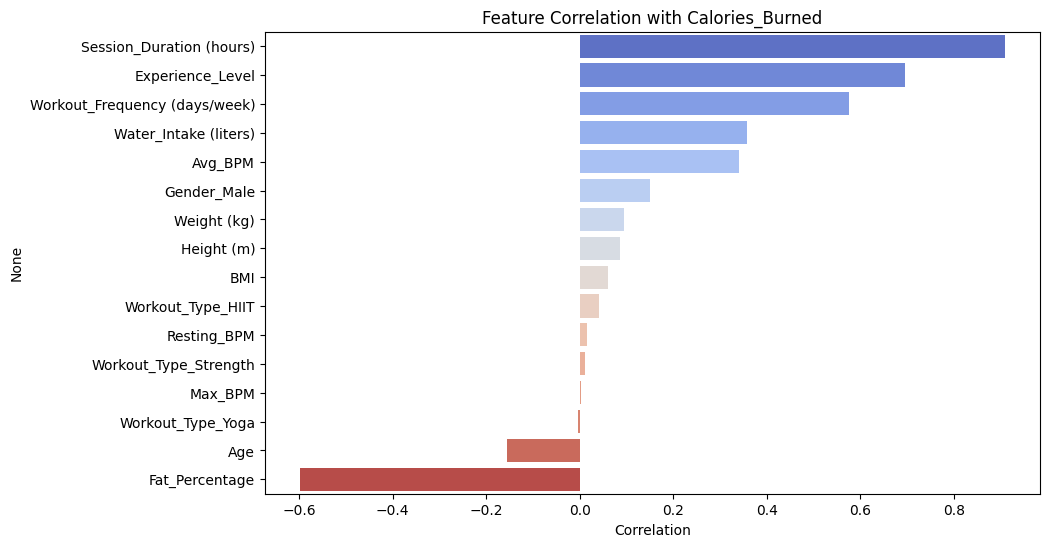

In [ ]:
# 1. Correlation with Target
corr_with_target = pd.DataFrame(X.corrwith(y), columns=["Correlation"])
corr_with_target = corr_with_target.sort_values(by="Correlation", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Correlation", y=corr_with_target.index, data=corr_with_target, palette="coolwarm")
plt.title("Feature Correlation with Calories_Burned")
plt.show()

In [ ]:
# Cell 11: Step 2 - Eliminate Highly Correlated Features
# Based on correlation matrix, drop BMI and Fat_Percentage (example, adjust based on actual correlations)
features_to_drop = ['BMI', 'Fat_Percentage']  # Adjust based on high_corr output
X_reduced = X.drop(columns=features_to_drop, errors='ignore')
print(f"Features after dropping highly correlated ones: {X_reduced.columns.tolist()}")
print(f"New features shape: {X_reduced.shape}")

Features after dropping highly correlated ones: ['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'Gender_Male', 'Workout_Type_HIIT', 'Workout_Type_Strength', 'Workout_Type_Yoga']
New features shape: (973, 14)


In [ ]:
# 2. Recursive Feature Elimination (RFE)
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=10)
rfe.fit(X, y)
print("\nTop features by RFE:")
print(pd.DataFrame({"Feature": X.columns, "Selected": rfe.support_})[rfe.support_])


Top features by RFE:
                     Feature  Selected
0                        Age      True
1                Weight (kg)      True
2                 Height (m)      True
4                    Avg_BPM      True
5                Resting_BPM      True
6   Session_Duration (hours)      True
7             Fat_Percentage      True
11                       BMI      True
12               Gender_Male      True
15         Workout_Type_Yoga      True


/tmp/ipython-input-3933316956.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")


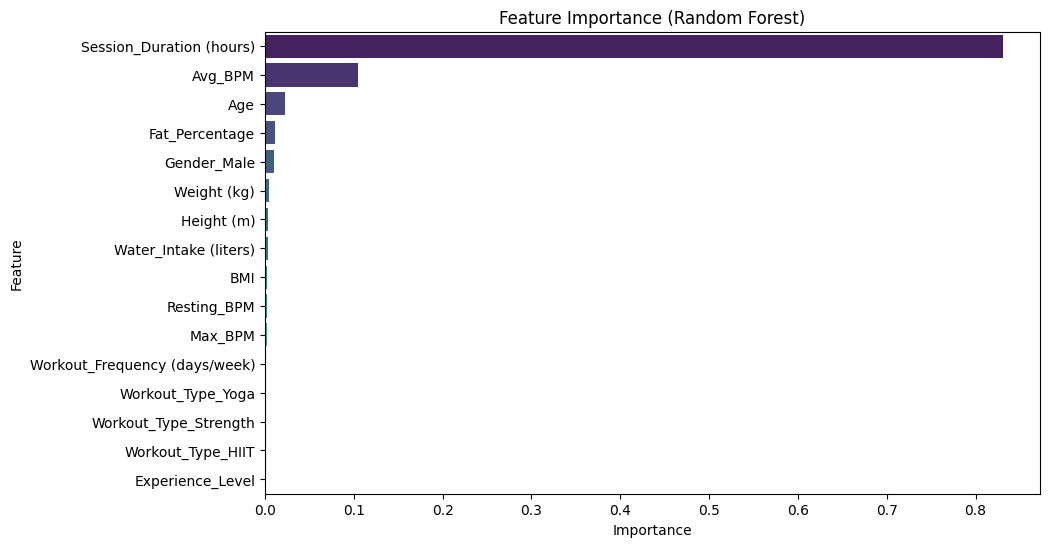

In [ ]:
# 3. Model-based Importance (Random Forest)
rf_temp = RandomForestRegressor(random_state=42)
rf_temp.fit(X, y)
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": rf_temp.feature_importances_}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.show()

# Optimization

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Model Optimization - Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
# 4. Randomized Search CV
search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=5,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
#Model Optimization - XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

In [ ]:
search_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=5,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
#Model Optimization - Decision Tree
param_dist_dt = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
# 4. Randomized Search CV for Decision Tree
search_dt = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=5,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
#Model Optimization - SVR
param_dist_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'epsilon': [0.1, 0.2, 0.5]
}

In [ ]:
# 4. Randomized Search CV for SVR
search_svr = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=param_dist_svr,
    n_iter=5,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
# Fit optimization for Decision Tree and SVR
search_dt.fit(X_train, y_train)
best_dt = search_dt.best_estimator_

search_svr.fit(X_train, y_train)
best_svr = search_svr.best_estimator_

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Fit Random Forest and XGBoost
search_rf.fit(X_train, y_train)
best_rf = search_rf.best_estimator_

search_xgb.fit(X_train, y_train)
best_xgb = search_xgb.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
print("Best Decision Tree Hyperparameters:", search_dt.best_params_)
print("Best SVR Hyperparameters:", search_svr.best_params_)
print("Best Random Forest Hyperparameters:", search_rf.best_params_)
print("Best XGB Hyperparameters:", search_xgb.best_params_)

Best Decision Tree Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 20}
Best SVR Hyperparameters: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 0.5, 'C': 10}
Best Random Forest Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'bootstrap': True}
Best XGB Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


# Performance Measurement

In [ ]:
model_results = []

def evaluate_model(model_name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    model_results.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })

    print(f"---- {model_name} ----")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}\n")

def show_results():
    results_df = pd.DataFrame(model_results).sort_values(by="RMSE")
    print("\nModel Performance Comparison:")
    print(results_df)
    return results_df

In [ ]:
evaluate_model("Random Forest", y_test, best_rf.predict(X_test))
evaluate_model("XGBoost", y_test, best_xgb.predict(X_test))
evaluate_model("Decision Tree", y_test, best_dt.predict(X_test))
evaluate_model("SVR", y_test, best_svr.predict(X_test))
evaluate_model("Linear Regression", y_test, lr_model.predict(X_test))

---- Random Forest ----
RMSE: 67.0608
MAE:  51.4674
R²:   0.9461

---- XGBoost ----
RMSE: 29.1868
MAE:  21.5479
R²:   0.9898

---- Decision Tree ----
RMSE: 67.9389
MAE:  52.3337
R²:   0.9447

---- SVR ----
RMSE: 42.1943
MAE:  31.2062
R²:   0.9787

---- Linear Regression ----
RMSE: 40.5731
MAE:  30.2701
R²:   0.9803



In [ ]:
results_df = show_results()


Model Performance Comparison:
               Model       RMSE        MAE        R²
1            XGBoost  29.186801  21.547937  0.989789
4  Linear Regression  40.573095  30.270140  0.980268
3                SVR  42.194348  31.206156  0.978659
0      Random Forest  67.060837  51.467416  0.946093
2      Decision Tree  67.938941  52.333675  0.944672


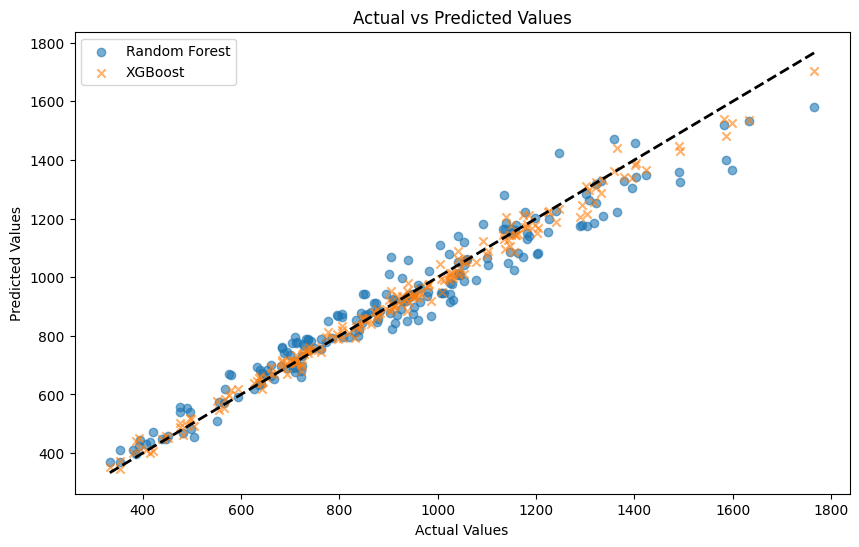

In [ ]:
plt.figure(figsize=(10,6))

# Random Forest
plt.scatter(y_test, best_rf.predict(X_test), alpha=0.6, label='Random Forest')

# XGBoost
plt.scatter(y_test, best_xgb.predict(X_test), alpha=0.6, label='XGBoost', marker='x')

# Ideal prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

# Performance Interpretation

In [ ]:
for row in model_results:
    print(f"{row['Model']}:")
    print(f"- R² score of {row['R²']:.2f} indicates that the model explains {row['R²']*100:.1f}% of variance in the target variable.")
    print(f"- MAE of {row['MAE']:.2f} shows the average magnitude of errors in predictions.")
    print(f"- RMSE of {row['RMSE']:.2f} emphasizes larger errors in predictions.")
    print("- Lower MAE and RMSE are better; higher R² is better.\n")

Random Forest:
- R² score of 0.95 indicates that the model explains 94.6% of variance in the target variable.
- MAE of 51.47 shows the average magnitude of errors in predictions.
- RMSE of 67.06 emphasizes larger errors in predictions.
- Lower MAE and RMSE are better; higher R² is better.

XGBoost:
- R² score of 0.99 indicates that the model explains 99.0% of variance in the target variable.
- MAE of 21.55 shows the average magnitude of errors in predictions.
- RMSE of 29.19 emphasizes larger errors in predictions.
- Lower MAE and RMSE are better; higher R² is better.

Decision Tree:
- R² score of 0.94 indicates that the model explains 94.5% of variance in the target variable.
- MAE of 52.33 shows the average magnitude of errors in predictions.
- RMSE of 67.94 emphasizes larger errors in predictions.
- Lower MAE and RMSE are better; higher R² is better.

SVR:
- R² score of 0.98 indicates that the model explains 97.9% of variance in the target variable.
- MAE of 31.21 shows the average 

In [ ]:
best_model = min(model_results, key=lambda x: x['RMSE'])
print(f"Recommended Model based on lowest RMSE: {best_model['Model']}")

Recommended Model based on lowest RMSE: XGBoost
